# Similarity analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import random
from sklearn.metrics.pairwise import cosine_similarity
import re
import pickle
import Levenshtein

from sample_helpers import *

# Helper functions

def get_bow_embeddings(model_cards_list):
    # Initialize the CountVectorizer
    vectorizer = CountVectorizer(
        max_features=512,
        #stop_words='english',
        lowercase=True,
        ngram_range=(1, 2)  # Include unigrams and bigrams
    )

    # Fit and transform the model cards to get bag-of-words embeddings
    bow_embeddings = vectorizer.fit_transform(model_cards_list)

    # Convert the embeddings to an array for easier manipulation
    bow_embeddings_array = bow_embeddings.toarray()

    return bow_embeddings_array

def get_tfidf_embeddings(model_cards_list): 
    tfidf_vectorizer = TfidfVectorizer(
        max_features=512,
        #stop_words='english',
        lowercase=True,
        ngram_range=(1, 2)  # Include unigrams and bigrams
    )

    tfidf_embeddings = tfidf_vectorizer.fit_transform(model_cards_list)

    return tfidf_embeddings.toarray()
    
def normalized_levenshtein_similarity(s1, s2):
    if not s1 and not s2:
        return 1.0  # both empty
    if not s1 or not s2:
        return 0.0  # one empty, one not

    distance = Levenshtein.distance(s1, s2)
    max_len = max(len(s1), len(s2))
    return 1 - (distance / max_len)

# Function to calculate cosine similarities for a given function and config
def calculate_similarities(func, config, n_samples=10000, embedding_attribute='tfidf_embedding', check_has_model_card=False):
    pairs, n_total = func(G, n_samples, config=config) #[0]
    #print(pairs[:5])
    similarities = []
    for u, v in pairs:
        if G.nodes[u] == {} or G.nodes[v] == {}:
            continue
        if check_has_model_card and (not G.nodes[u]['has_model_card'] or not G.nodes[v]['has_model_card']):
            continue
        embedding_u = G.nodes[u][embedding_attribute]
        embedding_v = G.nodes[v][embedding_attribute]
        if 'json' in embedding_attribute or 'modelCard' in embedding_attribute:
            cs = normalized_levenshtein_similarity(str(embedding_u), str(embedding_v))
        elif 'embedding' in embedding_attribute:
            #embedding_u = G.nodes[u][embedding_attribute] #.toarray().flatten()
            #embedding_v = G.nodes[v][embedding_attribute] #.toarray().flatten()
            cs = cosine_similarity([embedding_u], [embedding_v])[0][0]
        else:
            print('Error: embedding_attribute is not a recognized attribute')
            return None, None
        similarities.append(cs)

    return similarities, n_total

# Function to perform bootstrap sampling and calculate 95% confidence intervals
def bootstrap_confidence_intervals(data, n_samples=10000):
    means = []
    for _ in range(n_samples):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.mean(sample))
    lower_bound = np.percentile(means, 2.5)
    upper_bound = np.percentile(means, 97.5)
    original_mean = np.mean(data)
    return original_mean, lower_bound, upper_bound


def get_all_similarities(n_samples, embedding_attribute, n_bootstrap_samples, print_progress = False, check_has_model_card = False):
    
    # Initialize a dictionary to store cosine similarities for each configuration
    cosine_similarities = {
        'rando': {1: []},
        'duo': {1: []},
        'trio_1': {1: [], 2: []},
        'trio_2': {1: [], 2: [], 3: []},
        'quad_0': {1: [], 2: []},
        'quad_1': {1: [], 2: [], 3: [], 4: []},
        'quad_2': {1: [], 2: [], 3: [], 4: [], 5: []},
        'quad_3': {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
    }

    n_totals = {
        'rando': 0,
        'duo': 0,
        'trio_1': 0,
        'trio_2': 0,
        'quad_0': 0,
        'quad_1': 0,
        'quad_2': 0,
        'quad_3': 0
    }

    # Cycle through each function and configuration
    for config in cosine_similarities['rando']:
        cosine_similarities['rando'][config], n_totals['rando'] = calculate_similarities(rando, config, n_samples, embedding_attribute=embedding_attribute, check_has_model_card=check_has_model_card)
    if print_progress:
        print(f"rando configs {config}: {len(cosine_similarities['rando'][config])} similarities calculated each")

    for config in cosine_similarities['duo']:
        cosine_similarities['duo'][config], n_totals['duo'] = calculate_similarities(duo, config, n_samples, embedding_attribute=embedding_attribute, check_has_model_card=check_has_model_card)
    if print_progress:
        print(f"duo configs {config}: {len(cosine_similarities['duo'][config])} similarities calculated each")

    for config in cosine_similarities['trio_1']:
        cosine_similarities['trio_1'][config], n_totals['trio_1'] = calculate_similarities(trio_1, config, n_samples, embedding_attribute=embedding_attribute, check_has_model_card=check_has_model_card)
    if print_progress:
        print(f"trio_1 configs {config}: {len(cosine_similarities['trio_1'][config])} similarities calculated each")

    for config in cosine_similarities['trio_2']:
        cosine_similarities['trio_2'][config], n_totals['trio_2'] = calculate_similarities(trio_2, config, n_samples, embedding_attribute=embedding_attribute, check_has_model_card=check_has_model_card)
    if print_progress:
        print(f"trio_2 configs {config}: {len(cosine_similarities['trio_2'][config])} similarities calculated each")

    for config in cosine_similarities['quad_0']:
        cosine_similarities['quad_0'][config], n_totals['quad_0'] = calculate_similarities(quad_0, config, n_samples, embedding_attribute=embedding_attribute, check_has_model_card=check_has_model_card)
    if print_progress:
        print(f"quad_0 configs {config}: {len(cosine_similarities['quad_0'][config])} similarities calculated each")

    for config in cosine_similarities['quad_1']:
        cosine_similarities['quad_1'][config], n_totals['quad_1'] = calculate_similarities(quad_1, config, n_samples, embedding_attribute=embedding_attribute, check_has_model_card=check_has_model_card)
    if print_progress:
        print(f"quad_1 configs {config}: {len(cosine_similarities['quad_1'][config])} similarities calculated each") 

    for config in cosine_similarities['quad_2']:
        cosine_similarities['quad_2'][config], n_totals['quad_2'] = calculate_similarities(quad_2, config, n_samples, embedding_attribute=embedding_attribute, check_has_model_card=check_has_model_card)
    if print_progress:
        print(f"quad_2 configs {config}: {len(cosine_similarities['quad_2'][config])} similarities calculated each")

    for config in cosine_similarities['quad_3']:
        cosine_similarities['quad_3'][config], n_totals['quad_3'] = calculate_similarities(quad_3, config, n_samples, embedding_attribute=embedding_attribute, check_has_model_card=check_has_model_card)
    if print_progress:
        print(f"quad_3 configs {config}: {len(cosine_similarities['quad_3'][config])} similarities calculated each")
        print()
        print()

    # Perform bootstrap sampling for each function and configuration
    bootstrap_results = {}

    for func_name, configs in cosine_similarities.items():
        bootstrap_results[func_name] = {}
        for config, similarities in configs.items():
            if similarities:  # Ensure there are similarities to process
                original_mean, lower_bound, upper_bound = bootstrap_confidence_intervals(similarities, n_bootstrap_samples)
                bootstrap_results[func_name][config] = {
                    'original_mean': original_mean,
                    '95% CI': (lower_bound, upper_bound)
                }
            else:
                bootstrap_results[func_name][config] = {
                    'original_mean': None,
                    '95% CI': (None, None)
                }
    if print_progress:
        print("Bootstrap results calculated.")
        print()
        print()

    return cosine_similarities, n_totals, bootstrap_results

# Making the plot

def make_plot(cosine_similarities, bootstrap_results, y_label = 'Similarity', showplot = True, filename = None, existing_ax = None, color = 'black'):
    mean_estimates = []
    ci_lower_bounds = []
    ci_upper_bounds = []
    labels = []

    for func_name, configs in bootstrap_results.items():
        for config, result in configs.items():
            if result['original_mean'] is not None:
                mean_estimates.append(result['original_mean'])
                ci_lower_bounds.append(result['95% CI'][0])
                ci_upper_bounds.append(result['95% CI'][1])
                labels.append(f"{func_name} config {config}")

    # Create the plot for mean estimates and confidence intervals
    if existing_ax is None:
        fig, ax = plt.subplots(1, 8, figsize=(12, 4), width_ratios=[1,1,2,3,2,4,5,6])
    else:
        ax = existing_ax

    # Shade the background in white
    for i in range(1, 8):
        ax[i].axvspan(-0.5,5.5, color='white', alpha=1, linewidth=0)

    ax[0].errorbar([0], [mean_estimates[0]], yerr=np.array([(mean - lower, upper - mean) for mean, lower, upper in zip([mean_estimates[0]], [ci_lower_bounds[0]], [ci_upper_bounds[0]])]).T, fmt='o'
                , markersize= 2, capsize=3, capthick=.5, color=color)

    ax[1].errorbar([0], [mean_estimates[1]], yerr=np.array([(mean - lower, upper - mean) for mean, lower, upper in zip([mean_estimates[0]], [ci_lower_bounds[0]], [ci_upper_bounds[0]])]).T, fmt='o'
                , markersize= 2, capsize=3, capthick=.5, color=color)
    ax[2].errorbar(range(len(mean_estimates[2:4])), mean_estimates[2:4], yerr=np.array([(mean - lower, upper - mean) for mean, lower, upper in zip(mean_estimates[2:4], ci_lower_bounds[2:4], ci_upper_bounds[2:4])]).T, fmt='o'
                , markersize= 2, capsize=3, capthick=.5, color=color)
    ax[3].errorbar(range(len(mean_estimates[4:7])), mean_estimates[4:7], yerr=np.array([(mean - lower, upper - mean) for mean, lower, upper in zip(mean_estimates[4:7], ci_lower_bounds[4:7], ci_upper_bounds[4:7])]).T, fmt='o'
                , markersize= 2, capsize=3, capthick=.5, color=color)
    ax[4].errorbar(range(len(mean_estimates[7:9])), mean_estimates[7:9], yerr=np.array([(mean - lower, upper - mean) for mean, lower, upper in zip(mean_estimates[7:9], ci_lower_bounds[7:9], ci_upper_bounds[7:9])]).T, fmt='o'
                , markersize= 2, capsize=3, capthick=.5, color=color)
    ax[5].errorbar(range(len(mean_estimates[9:13])), mean_estimates[9:13], yerr=np.array([(mean - lower, upper - mean) for mean, lower, upper in zip(mean_estimates[9:13], ci_lower_bounds[9:13], ci_upper_bounds[9:13])]).T, fmt='o'
                , markersize= 2, capsize=3, capthick=.5, color=color)
    ax[6].errorbar(range(len(mean_estimates[13:18])), mean_estimates[13:18], yerr=np.array([(mean - lower, upper - mean) for mean, lower, upper in zip(mean_estimates[13:18], ci_lower_bounds[13:18], ci_upper_bounds[13:18])]).T, fmt='o'
                , markersize= 2, capsize=3, capthick=.5, color=color)
    ax[7].errorbar(range(len(mean_estimates[18:24])), mean_estimates[18:24], yerr=np.array([(mean - lower, upper - mean) for mean, lower, upper in zip(mean_estimates[18:24], ci_lower_bounds[18:24], ci_upper_bounds[18:24])]).T, fmt='o'
                , markersize=2, capsize=3, capthick=.5, color=color)

    # Shade the background in gray shades
    ax[1].axvspan(-0.5,0.5, color='gray', alpha=0.1, linewidth=0, label = '1 generations')
    ax[2].axvspan(-0.5,0.5, color='gray', alpha=0.1, linewidth=0, label = '1 generations')
    ax[2].axvspan(0.5, 1.5, color='white', alpha=0.1, linewidth=0, label = '0 generations')
    ax[3].axvspan(-0.5,0.5, color='gray', alpha=0.2, linewidth=0, label = '2 generations')
    ax[3].axvspan(0.5, 2.5, color='gray', alpha=0.1, linewidth=0, label = '1 generations')
    ax[4].axvspan(-0.5,0.5, color='gray', alpha=0.1, linewidth=0, label = '1 generations')
    ax[4].axvspan(0.5, 2.5, color='gray', alpha=0.0, linewidth=0, label = '0 generations')
    ax[5].axvspan(-0.5,0.5, color='gray', alpha=0.2, linewidth=0, label = '2 generations')
    ax[5].axvspan(0.5, 2.5, color='gray', alpha=0.1, linewidth=0, label = '1 generations')
    ax[4].axvspan(2.5, 3.5, color='white', alpha=0.1, linewidth=0, label = '0 generations')
    ax[6].axvspan(-0.5,0.5, color='gray', alpha=0.2, linewidth=0, label = '2 generations')
    ax[6].axvspan(0.5, 3.5, color='gray', alpha=0.1, linewidth=0, label = '1 generations')
    ax[5].axvspan(3.5, 4.5, color='white', alpha=0.1, linewidth=0, label = '0 generations')
    ax[7].axvspan(-0.5,0.5, color='gray', alpha=0.3, linewidth=0, label = '3 generations apart')
    ax[7].axvspan(.5, 2.5, color='gray', alpha=0.2, linewidth=0, label = '2 generations apart')
    ax[7].axvspan(2.5, 5.5, color='gray', alpha=0.1, linewidth=0, label = '1 generation apart')
    ax[7].axvspan(5.5, 5.501, color='white', alpha=0.1, label = 'same generation')
    

    # Set the facecolor and edgecolor of the legend to white with full opacity
    # Only set a legend if there is not already a legend showing.
    if ax[7].get_legend() is None:  
        legend = ax[7].legend(loc='lower right', fontsize=10, frameon=True)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(1)

    labels = np.array(labels)
    ax[0].set_xticks(ticks=[0], labels=[labels[0]], rotation=90, ha='right')
    ax[0].set_xlim(min([0])-0.5, max([0])+0.5)
    ax[1].set_xticks(ticks=[0], labels=[labels[1]], rotation=90, ha='right')
    ax[1].set_xlim(min([0])-0.5, max([0])+0.5)
    ax[2].set_xticks(ticks=range(len(labels[2:4])), labels=labels[2:4], rotation=90, ha='right')
    ax[2].set_xlim(min(range(len(labels[2:4])))-0.5, max(range(len(labels[2:4])))+0.5)
    ax[3].set_xticks(ticks=range(len(labels[4:7])), labels=labels[4:7], rotation=90, ha='right')
    ax[3].set_xlim(min(range(len(labels[4:7])))-0.5, max(range(len(labels[4:7])))+0.5)
    ax[4].set_xticks(ticks=range(len(labels[7:9])), labels=labels[7:9], rotation=90, ha='right')
    ax[4].set_xlim(min(range(len(labels[7:9])))-0.5, max(range(len(labels[7:9])))+0.5)
    ax[5].set_xticks(ticks=range(len(labels[9:13])), labels=labels[9:13], rotation=90, ha='right')
    ax[5].set_xlim(min(range(len(labels[9:13])))-0.5, max(range(len(labels[9:13])))+0.5)
    ax[6].set_xticks(ticks=range(len(labels[13:18])), labels=labels[13:18], rotation=90, ha='right')
    ax[6].set_xlim(min(range(len(labels[13:18])))-0.5, max(range(len(labels[13:18])))+0.5)
    ax[7].set_xticks(ticks=range(len(labels[18:24])), labels=labels[18:24], rotation=90, ha='right')
    ax[7].set_xlim(min(range(len(labels[18:24])))-0.5, max(range(len(labels[18:24])))+0.5)
    #ax[6].set_xticks(ticks=range(len(labels[16:22])), labels=labels[16:22], rotation=90, ha='right')
    #ax[6].set_xlim(min(range(len(labels[16:22])))-0.5, max(range(len(labels[16:22])))+0.5)

    for i in range(8):  
        ax[i].set_ylim(0, 1)
        ax[i].set_yticks([0,.5,1])
        if i > 0:
            ax[i].set_yticklabels([])# [0,1])
            ax[i].set_yticks([])# [0,1])
        ax[i].set_xlabel(' ')
        for j in range(len(ax[i].get_xticks())):
            ax[i].axvline(x=j+0.5, color='white', linewidth=0.5, alpha=1)
            ax[i].axvline(x=j+0.5, color='black', linewidth=0.5, alpha=0.5, linestyle='--')
            #ax[i].grid(True, which='major', axis='x', alpha=0.5, linewidth=0.5)

    ax[0].set_xlim()
    ax[0].set_ylabel(y_label)  #('Levenshtein Distance (normalized)')

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=400, bbox_inches='tight')
    if showplot:
        plt.show()
    #else:
    #    plt.close()


## Similarity using metadata

In [2]:
#with open('data/ai_ecosystem_graph_finetune_fulljson.pkl', 'rb') as f:
#    G = pickle.load(f)
#print("Graph loaded.")

with open('data/ai_ecosystem_graph_nomerges_fulljson.pkl', 'rb') as f:
    G = pickle.load(f)
print("Graph loaded.")


Graph loaded.


In [4]:
# Remove quantization edges
edges_to_remove = [(i, j) for i, j, data in G.edges(data=True) if data['edge_type'] == 'quantized']
G.remove_edges_from(edges_to_remove)

In [5]:
# Get the list of model_ids and jsons
list_of_model_ids = []
list_of_modelcards = []
for node in G.nodes():
    list_of_model_ids.append(node)
    list_of_modelcards.append(G.nodes[node]['full_json'])
print("Lists attained.")

# FOR BOW
bow_embeddings = get_bow_embeddings(list_of_modelcards)
print("BOW embeddings attained.")
for model_id, index in zip(list_of_model_ids, range(len(list_of_model_ids))):
    G.nodes[model_id]['bow_embedding'] = bow_embeddings[index]
print("BOW embeddings added to graph.")

# For TF-IDF
tfidf_embeddings = get_tfidf_embeddings(list_of_modelcards)
print("TF-IDF embeddings attained.")
for model_id, index in zip(list_of_model_ids, range(len(list_of_model_ids))):
    G.nodes[model_id]['tfidf_embedding'] = tfidf_embeddings[index]
print("TF-IDF embeddings added to graph.")

Lists attained.
BOW embeddings attained.
BOW embeddings added to graph.
TF-IDF embeddings attained.
TF-IDF embeddings added to graph.


In [7]:
n_samples = 500 # 5000
n_bootstrap_samples = 10000
print_progress = False

cosine_similarities_levenshtein, n_totals_levenshtein, bootstrap_results_levenshtein = get_all_similarities(n_samples, 'full_json', n_bootstrap_samples, print_progress=print_progress)
print("Completed Levenshtein")
cosine_similarities_bow, n_totals_bow, bootstrap_results_bow = get_all_similarities(n_samples, 'bow_embedding', n_bootstrap_samples, print_progress=print_progress)
print("Completed BOW")
cosine_similarities_tfidf, n_totals_tfidf, bootstrap_results_tfidf = get_all_similarities(n_samples, 'tfidf_embedding', n_bootstrap_samples, print_progress=print_progress)
print("Completed TF-IDF")

Completed Levenshtein
Completed BOW
Completed TF-IDF


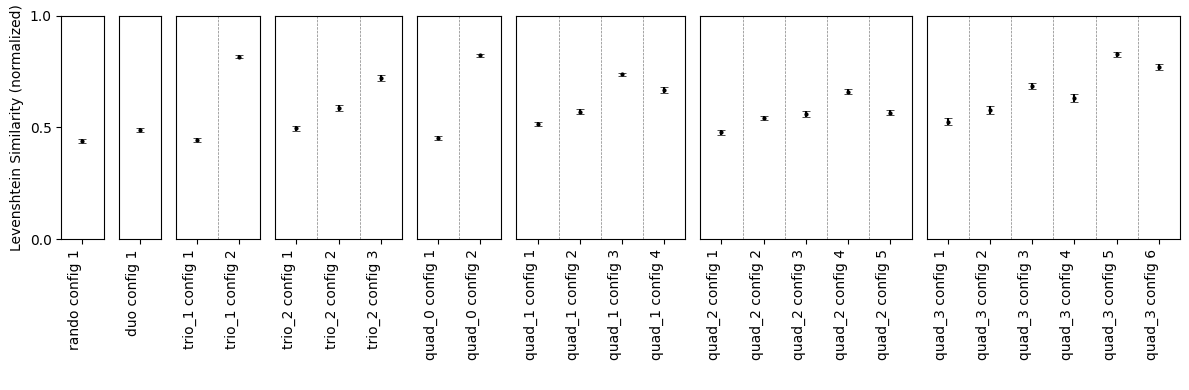

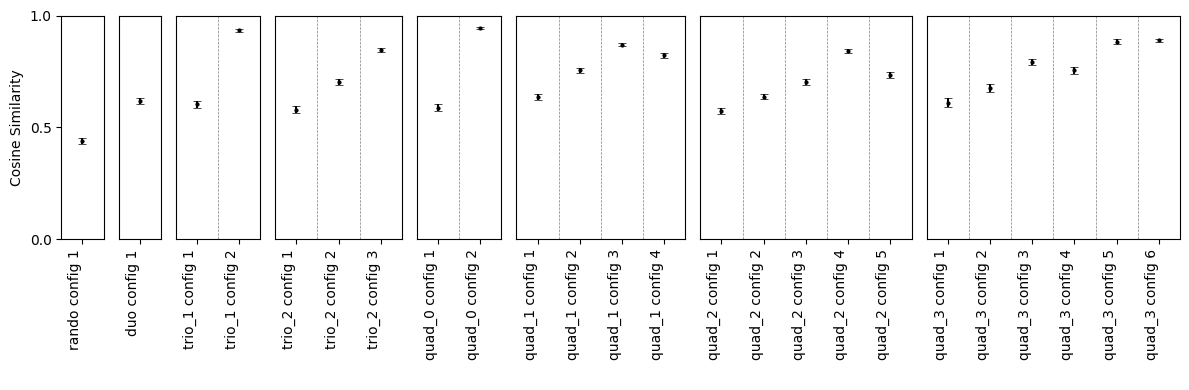

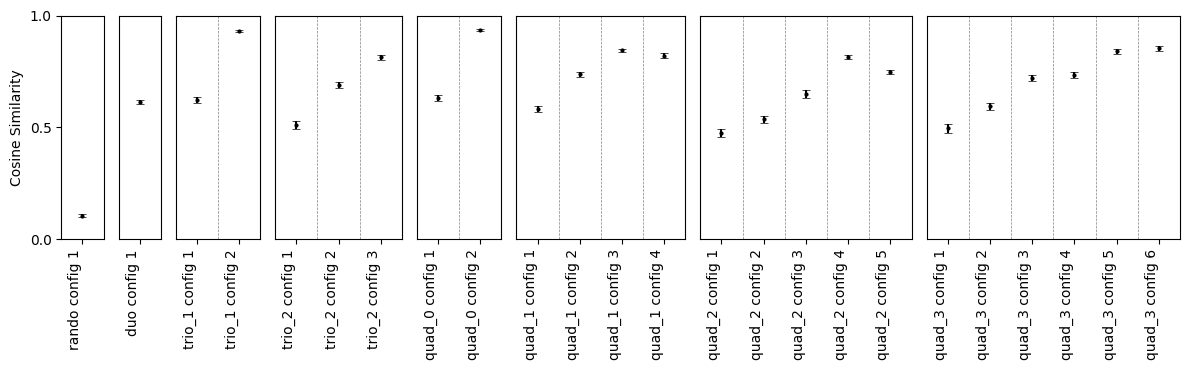

In [10]:
make_plot(cosine_similarities_levenshtein, bootstrap_results_levenshtein, y_label='Levenshtein Similarity (normalized)', showplot=False, existing_ax = None#, filename = 'figures/metadata_finetune_levenshtein_aug8.png'
    )
make_plot(cosine_similarities_bow, bootstrap_results_bow, y_label='Cosine Similarity', showplot=False, existing_ax = None#, filename = 'figures/metadata_finetune_bow.png'
    )
make_plot(cosine_similarities_tfidf, bootstrap_results_tfidf, y_label='Cosine Similarity', showplot=False, existing_ax = None#, filename = 'figures/metadata_finetune_tfidf.png'
    )


In [6]:
# To conserve memory, delete the graph
del G

## Similarity using model cards

In [10]:
with open('data/ai_ecosystem_graph_finetune_modelcards.pkl', 'rb') as f:
    G = pickle.load(f)

In [11]:
min_length = 512
max_length = 512
list_of_model_ids = []
list_of_modelcards = []
for node in G.nodes():
    G.nodes[node]['has_model_card'] = False
    if G.nodes[node]['modelCard'] is not None and G.nodes[node]['model_card_length_characters'] >= min_length and not bool(G.nodes[node]['model_card_automatically_generated']):
        G.nodes[node]['has_model_card'] = True
        list_of_model_ids.append(node)
        if G.nodes[node]['model_card_length_characters'] <= max_length:
            list_of_modelcards.append(G.nodes[node]['modelCard'])
            G.nodes[node]['modelCard_clean'] = G.nodes[node]['modelCard']
        else:
            card_clean = G.nodes[node]['modelCard'][:max_length]
            list_of_modelcards.append(card_clean)
            G.nodes[node]['modelCard_clean'] = card_clean

print(len(list_of_model_ids))
print(len(list_of_modelcards))


618531
618531


In [12]:
# FOR BOW
bow_embeddings = get_bow_embeddings(list_of_modelcards)
print("BOW embeddings attained.")
for model_id, index in zip(list_of_model_ids, range(len(list_of_model_ids))):
    G.nodes[model_id]['bow_embedding'] = bow_embeddings[index]
print("BOW embeddings added to graph.")

# For TF-IDF
tfidf_embeddings = get_tfidf_embeddings(list_of_modelcards)
print("TF-IDF embeddings attained.")
for model_id, index in zip(list_of_model_ids, range(len(list_of_model_ids))):
    G.nodes[model_id]['tfidf_embedding'] = tfidf_embeddings[index]
print("TF-IDF embeddings added to graph.")

BOW embeddings attained.
BOW embeddings added to graph.
TF-IDF embeddings attained.
TF-IDF embeddings added to graph.


In [ ]:
# Define the parameters
n_samples = 1000 #5000
n_bootstrap_samples = 10000 
print_progress = True

cosine_similarities_levenshtein, n_totals_levenshtein, bootstrap_results_levenshtein = get_all_similarities(n_samples, 'modelCard_clean', n_bootstrap_samples, print_progress=print_progress, check_has_model_card=True)
print("Completed Levenshtein")
print()
cosine_similarities_bow, n_totals_bow, bootstrap_results_bow = get_all_similarities(n_samples, 'bow_embedding', n_bootstrap_samples, print_progress=print_progress, check_has_model_card=True)
print("Completed BOW")
print()
cosine_similarities_tfidf, n_totals_tfidf, bootstrap_results_tfidf = get_all_similarities(n_samples, 'tfidf_embedding', n_bootstrap_samples, print_progress=print_progress, check_has_model_card=True)
print("Completed TF-IDF")
print()

rando configs 1: 552 similarities calculated each
duo configs 1: 2165 similarities calculated each
trio_1 configs 2: 809 similarities calculated each
trio_2 configs 3: 3937 similarities calculated each
quad_0 configs 2: 245 similarities calculated each
quad_1 configs 4: 3148 similarities calculated each
quad_2 configs 5: 1993 similarities calculated each
quad_3 configs 6: 4047 similarities calculated each


Bootstrap results calculated.


Completed Levenshtein

rando configs 1: 579 similarities calculated each
duo configs 1: 2199 similarities calculated each
trio_1 configs 2: 772 similarities calculated each
trio_2 configs 3: 3950 similarities calculated each
quad_0 configs 2: 259 similarities calculated each
quad_1 configs 4: 3122 similarities calculated each
quad_2 configs 5: 2054 similarities calculated each
quad_3 configs 6: 4074 similarities calculated each


Bootstrap results calculated.


Completed BOW

rando configs 1: 544 similarities calculated each
duo configs 1: 2183 simila

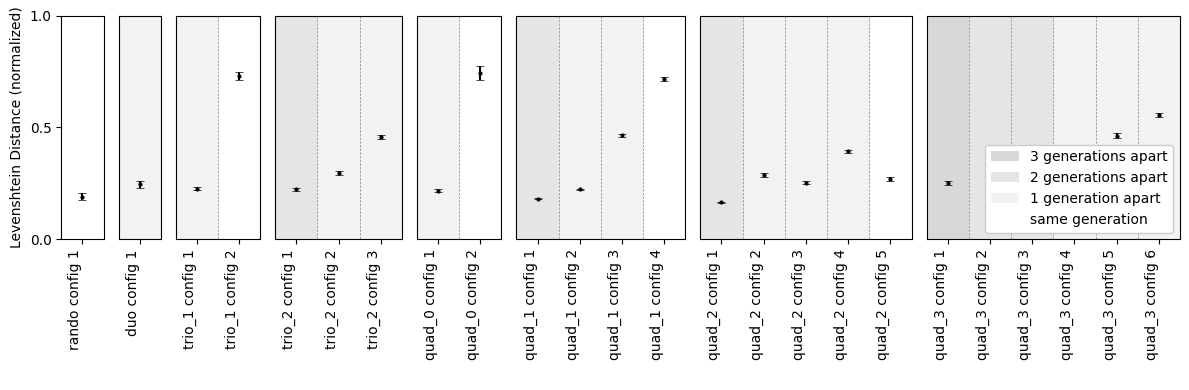

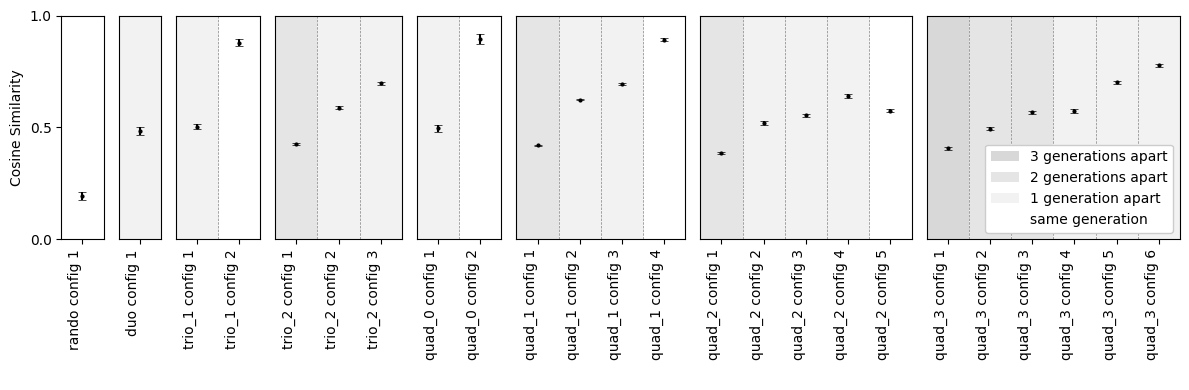

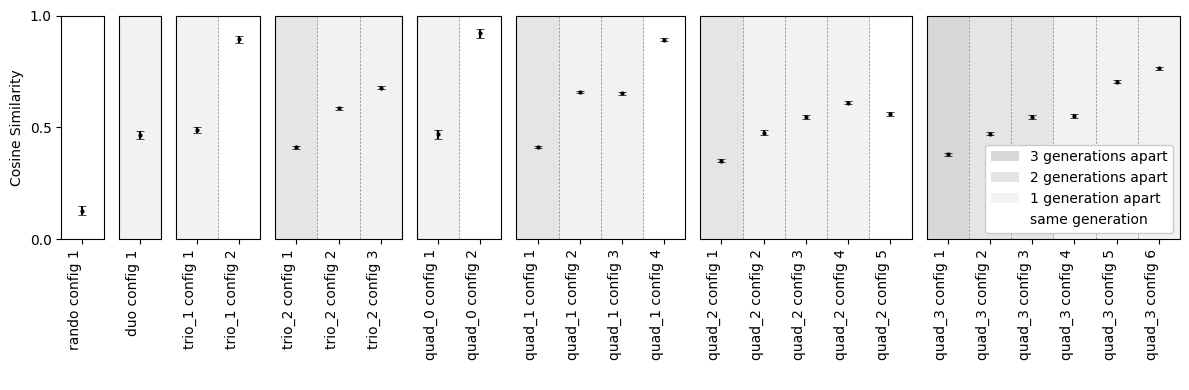

In [ ]:
# Plot the results

make_plot(cosine_similarities_levenshtein, bootstrap_results_levenshtein, y_label='Levenshtein Similarity (normalized)', showplot=False, existing_ax = None#, filename = 'figures/modelcards_finetune_levenshtein_aug4.png'
    )
make_plot(cosine_similarities_bow, bootstrap_results_bow, y_label='Cosine Similarity', showplot=False, existing_ax = None#, filename = 'figures/modelcards_finetune_bow_aug4.png'
    )
make_plot(cosine_similarities_tfidf, bootstrap_results_tfidf, y_label='Cosine Similarity', showplot=False, existing_ax = None#, filename = 'figures/modelcards_finetune_tfidf_aug4.png'
    )
